In [ ]:
function ConnectButton(){
  console.log("Connect pushed");
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click()
}
var colab = setInterval(ConnectButton,300000);

In [ ]:
!pip install paddlepaddle-gpu==2.4.2.post117 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
!pip install paddleocr

In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR
!pip install -r /content/PaddleOCR/requirements.txt

In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn

In [4]:
!ngrok config add-authtoken 2RD3s7IecoT14nPwcYYUk7VmxZs_69qfmAW7jdYTCrsoejav1

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [76]:
# detect

!python3 PaddleOCR/tools/infer_det.py -c det_mv3_db.yml -o Global.infer_img="/content/images/img1.png" PostProcess.box_thresh=0.6 PostProcess.unclip_ratio=2.0

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr

mkdir: cannot create directory ‘croped_images’: File exists


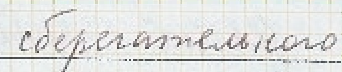

In [28]:
import json
from PIL import Image
import cv2

data = {}
with open("/content/output/det_db/predicts_db.txt") as f:
    filename, json_str = f.read().split('\t')
    data = json.loads(json_str)


image_boxes = []
for obj in data:
    image_boxes.append(obj['points'])


!mkdir croped_images
origin = Image.open("/content/det_ex.png")
images = []
ctr = 0
for idx, box in enumerate(image_boxes):
    x1, y1 = box[0]
    x2, y2 = box[2]
    if x2 - x1 < 35 or y2 - y1 < 15:
        continue
    origin.crop((x1, y1, x2, y2)).save(f"croped_images/img{ctr}.png")
    ctr += 1

Image.open('croped_images/img1.png').show()

In [44]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import mobilenet_v3_large

class ClassifierMobileNetV3(nn.Module):
    def __init__(self, num_classes=3):
        super(ClassifierMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model
        self.model = mobilenet_v3_large(pretrained=True)

        # Replace last layer to match desired number of classes
        num_features = self.model.classifier[-1].in_features

        # Define custom classifier layer for our 3-class problem.
        self.model.classifier[-1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model and print its structure
model = ClassifierMobileNetV3()
model.load_state_dict(torch.load('/content/classifier.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
import os
from torchvision.transforms import Resize, ToTensor, Normalize, ToPILImage
import numpy as np
import torch


def prepare_img(img):
    tr1 = transforms.ToPILImage()
    tr2 = transforms.Resize((224, 224)),
    tr3 = transforms.ToTensor(),
    tr4 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224 , 0.225])
    # img = tr1(img)
    print(img)
    img = tr2(img)
    img = img.convert('RGB')
    img = tr3(img)
    img = tr4(img)
    return img





In [111]:
# recognize
!python3 PaddleOCR/tools/infer_rec.py -c rec_cyrillic_lite_train.yml -o Global.pretrained_model=lite_ocr  Global.infer_img=rus_text.jpg

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr

In [63]:
!mkdir images

In [120]:
with open('/content/preds.txt') as f:
    print(f.read().split('\n')[-3].split('\t')[1].strip()[8:])

Линейное


In [ ]:
from fastapi import FastAPI, Request
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import base64
import os
import time
from paddleocr import PaddleOCR


app = FastAPI()

@app.post('/process')
async def home(request: Request):
    !rm -rf /content/images
    !rm -rf /content/croped_images
    !mkdir /content/images
    !mkdir /content/croped_images
    images = await request.json()
    print(images)


    for idx, b64image in images.items():
        with open(f"images/img{idx}.png", "wb") as f:
            f.write(base64.b64decode(b64image.encode('utf-8')))


    ctr = 0
    for filename in os.listdir("images"):
        print(filename)
        os.system(f'python3 PaddleOCR/tools/infer_det.py -c det_mv3_db.yml -o Global.infer_img="images/{filename}" PostProcess.box_thresh=0.6 PostProcess.unclip_ratio=2.0')
        time.sleep(10)

        data = {}
        with open("/content/output/det_db/predicts_db.txt") as f:
            img_filename, json_str = f.read().split('\t')
            data = json.loads(json_str)

        image_boxes = []
        for obj in data:
            image_boxes.append(obj['points'])


        origin = Image.open(f"/content/images/{filename}")
        images = []

        for idx, box in enumerate(image_boxes):
            x1, y1 = box[0]
            x2, y2 = box[2]
            if x2 - x1 < 35 or y2 - y1 < 15:
                continue
            origin.crop((x1, y1, x2, y2)).save(f"/content/croped_images/img{ctr}.png")
            ctr += 1


        images = []
        for filename in sorted(list(os.listdir('/content/croped_images'))):
            if not filename.endswith('.png'):
                continue
            img = Image.open(f'/content/croped_images/{filename}')
            img = img.resize((224, 224))
            img = ToTensor()(img)
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224 , 0.225])(img)
            images.append((img, f'/content/croped_images/{filename}'))

        model.eval()
        result = []
        for img, path in images:
            outputs = model(img.reshape(1, 3, 224, 224))
            _, predicted = torch.max(outputs.data, 1)
            result.append((predicted, path))

        tokens = []
        for t, path in result:
            print(t, path)
            if t >= 0:
              os.system(f'python3 PaddleOCR/tools/infer_rec.py -c rec_cyrillic_lite_train.yml -o Global.pretrained_model=lite_ocr  Global.infer_img={path} > /content/preds.txt')
              time.sleep(7)
              with open('/content/preds.txt') as f:
                  tokens.append((0, f.read().split('\n')[-3].split('\t')[1].strip()[8:]))
    return json.dumps(tokens)




ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Public URL: https://090a-34-143-255-213.ngrok-free.app


INFO:     Started server process [2230]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


{'0': '/9j/4AAQSkZJRgABAQEAeAB4AAD/2wBDAAQDAwQDAwQEAwQFBAQFBgoHBgYGBg0JCggKDw0QEA8NDw4RExgUERIXEg4PFRwVFxkZGxsbEBQdHx0aHxgaGxr/2wBDAQQFBQYFBgwHBwwaEQ8RGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhr/wgARCAMUBQADASIAAhEBAxEB/8QAGwAAAwEBAQEBAAAAAAAAAAAAAgMEAQAFBgf/xAAZAQEBAQEBAQAAAAAAAAAAAAABAAIDBAX/2gAMAwEAAhADEAAAAf3/ALuru7C3h5C4Ok+DqPg4D4Oo+zp3g2C4ekuDoPg6j4OY+DaLg0S4cg+DEZy+lnBpFw8pcOlvZiFw4R8GyXZybw8JcGwXYNHwdR8GyXD0Fw4x8G0XD1F2ZJcPEXDjHw9BcPEXD1Fw9JcPUXD0Fw9RcGqXD1Fw7W8PUXZhFw9BcPMXYNHw5R8HEfB1Hwcx4Hzdx+l74ek4fX95fXP1B835i391vzPpR6neUMev3zKbX1pJJ9jOXto+DCZw9JcPQXDzFwcR8HMfD1FwbRdmEXB1HwdR8HUfBslw9BcOrubhDHTLkw5mQRIYJcrYZwql4dHyfQzE9R5oKDORsmyJ5M6Xaq6Zdeh0iHXp5IvJdsDNFneW+K+89w1F55VdkYWvRGNMekE6Ut5XUzpnCWJbQdhwnT2g0gpo8uqeWOqvEZVGylDmRnLyiZFOTgNgpVVQCsmizWQXaWMmcrWeVtj0VobazVPRDktyaxBWmMk1ahUlzcMw1Xk+TTs22WlIYt6cpzVNDFtSpcxcbxgLPnPqvJ14ZfOv8i8tTfC9a6IbLWs93mNs22eVget6Hzf0Fj1eTKfX9EvPJbC8x+WrvNcatzzXJWtSUtxCgtxI1RyuUiQwuJBxjJXcujR5XXm/FizxxdOKdidTFQN2bnRTLV5+AWyFl